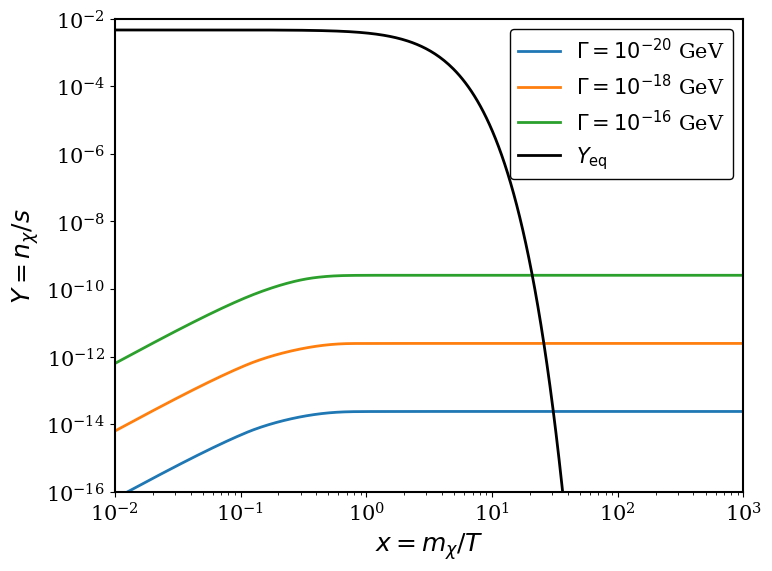

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn as besselk

# --- Constants and parameters ---
Mpl = 1.2209e19      # Planck mass [GeV]
OMEGA_PREF = 2.742e8 # Omega h^2 = OMEGA_PREF * (m/GeV) * Y0
m_chi   = 100.0     # DM mass [GeV]
m_phi   = 1000.0    # Parent mass [GeV]
Gamma_list = [1e-20, 1e-18, 1e-16]  # Decay widths [GeV]

# --- Helper functions ---
def Y_eq(x, m, g=2, g_s=100.0):                                         #Equilibrium yield for DM chi
    pref = 45.0 / (4.0 * np.pi**4)
    return pref * (g / g_s) * x**2 * besselk(2, x)

def dYdx(x, Y, m_chi, m_phi, Gamma_phi, g_phi=1, g_star=100):           #dY/dx for freeze-in production via phi to DM decays.
    arg = (m_phi/m_chi) * x
    prefactor = (135 * g_phi) / (8*np.pi**4) * (Mpl * Gamma_phi) / (1.66 * g_star**1.5 * m_phi**2)
    return prefactor * x**2 * besselk(1, arg)

def solve_Y_freezein(m_chi, m_phi, Gamma_phi,x_min=1e-3, x_max=1e3, nx=500):    #Solve freeze-in yield equation
    x_eval = np.logspace(np.log10(x_min), np.log10(x_max), nx)

    sol = solve_ivp(lambda xx, YY: dYdx(xx, YY, m_chi, m_phi, Gamma_phi),(x_min, x_max), [0.0],t_eval=x_eval,rtol=1e-8, atol=1e-12)
    if not sol.success:
        raise RuntimeError("ODE solver failed: " + str(sol.message))
    x, Y = sol.t, sol.y[0]
    Y_final = Y[-1]
    Omega_h2 = OMEGA_PREF * m_chi * Y_final
    return x, Y, Y_final, Omega_h2





# --- Plot ---
colors = ["tab:blue", "tab:orange", "tab:green"]
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})
plt.figure(figsize=(8,6))

results = []
for Gamma_phi, color in zip(Gamma_list, colors):
    x, Y, Yf, Omega = solve_Y_freezein(m_chi, m_phi, Gamma_phi)
    results.append((Gamma_phi, Yf, Omega))
    plt.plot(x, Y, lw=2, color=color,label=fr"$\Gamma=10^{{{int(np.log10(Gamma_phi))}}}$ GeV")
    
x_ref = np.logspace(-3, 3, 500)
Yeq_ref = Y_eq(x_ref, m_chi)
plt.plot(x_ref, Yeq_ref, 'k', lw=2.0, label=r"$Y_\mathrm{eq}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$x = m_\chi/T$")
plt.ylabel(r"$Y = n_\chi/s$")
plt.ylim(1e-16, 1e-2)
plt.xlim(1e-2, 1e3)
plt.legend()
plt.tight_layout()
plt.show()
